##Submission 2
####Nama : Muhammad Ridho Abdillah
####Email : ridhoabdi101@gmail.com
####Kelas : Dicoding - Belajar Pengembangan Machine Learning

###Informasi Dataset
Dataset ini diperoleh dari website Kaggle yang berjudul Austin Weather. Berikut adalah link dataset yang digunakan pada proyek ini:
https://www.kaggle.com/datasets/grubenm/austin-weather

###Membuat Model Machine Learning dengan Data Time Series

In [46]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [47]:
data_train = pd.read_csv('austin_weather.csv')
data_train

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2017-07-27,103,89,75,71,67,61,82,54,25,...,29.97,29.88,10,10,10,12,5,21,0,
1315,2017-07-28,105,91,76,71,64,55,87,54,20,...,29.9,29.81,10,10,10,14,5,20,0,
1316,2017-07-29,107,92,77,72,64,55,82,51,19,...,29.86,29.79,10,10,10,12,4,17,0,
1317,2017-07-30,106,93,79,70,68,63,69,48,27,...,29.91,29.87,10,10,10,13,4,20,0,


In [48]:
data_train.isnull().sum()

Date                          0
TempHighF                     0
TempAvgF                      0
TempLowF                      0
DewPointHighF                 0
DewPointAvgF                  0
DewPointLowF                  0
HumidityHighPercent           0
HumidityAvgPercent            0
HumidityLowPercent            0
SeaLevelPressureHighInches    0
SeaLevelPressureAvgInches     0
SeaLevelPressureLowInches     0
VisibilityHighMiles           0
VisibilityAvgMiles            0
VisibilityLowMiles            0
WindHighMPH                   0
WindAvgMPH                    0
WindGustMPH                   0
PrecipitationSumInches        0
Events                        0
dtype: int64

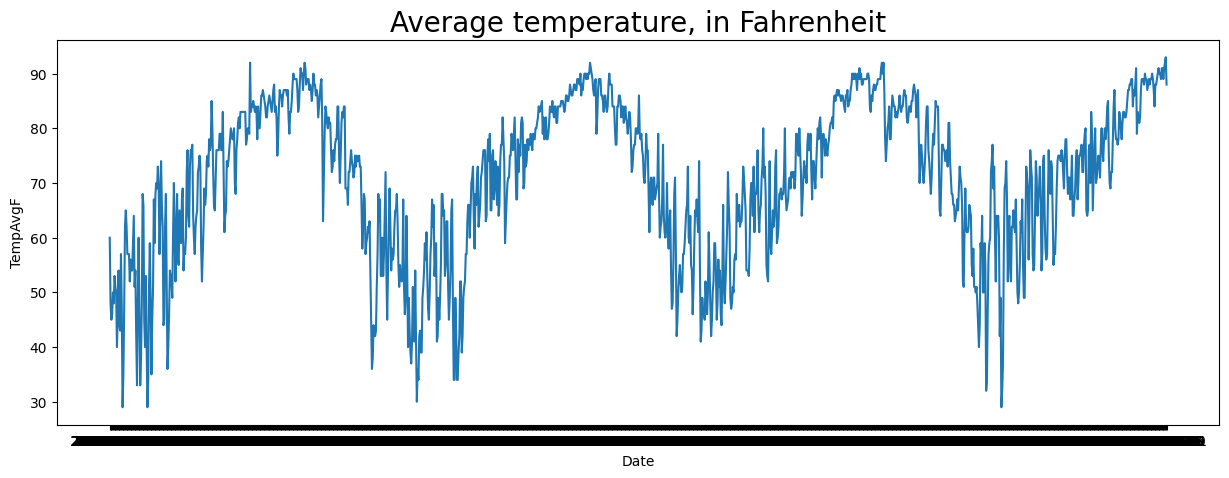

In [49]:
dates = data_train['Date'].values
temp = data_train['TempAvgF'].values

plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('TempAvgF')
plt.plot(dates, temp)
plt.title('Average temperature, in Fahrenheit', fontsize=20);

In [50]:
dates = data_train['Date'].values
temp = data_train['TempAvgF'].values

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 42 , shuffle=False)
print(len(x_train), len(x_test))

1055 264


In [52]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    series = tf.cast(series, tf.float64)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [53]:
x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [54]:
threshold = (temp.max() - temp.min()) * 10 / 100
print(threshold)

6.4


In [55]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae') < threshold):
      print("\nMAE < 10% skala data, stop training.")
      self.model.stop_training = True

callbacks = myCallback()

In [56]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/100
10/10 [==============================] - 9s 450ms/step - loss: 71.3222 - mae: 71.8222 - val_loss: 73.6789 - val_mae: 74.1789
Epoch 2/100
10/10 [==============================] - 5s 448ms/step - loss: 71.2595 - mae: 71.7595 - val_loss: 73.6024 - val_mae: 74.1024
Epoch 3/100
10/10 [==============================] - 4s 357ms/step - loss: 71.1767 - mae: 71.6767 - val_loss: 73.5112 - val_mae: 74.0112
Epoch 4/100
10/10 [==============================] - 4s 355ms/step - loss: 71.0864 - mae: 71.5864 - val_loss: 73.4200 - val_mae: 73.9200
Epoch 5/100
10/10 [==============================] - 4s 395ms/step - loss: 70.9988 - mae: 71.4988 - val_loss: 73.3276 - val_mae: 73.8276
Epoch 6/100
10/10 [==============================] - 3s 326ms/step - loss: 70.8808 - mae: 71.3808 - val_loss: 73.1723 - val_mae: 73.6723
Epoch 7/100
10/10 [==============================] - 5s 458ms/step - loss: 70.7189 - mae: 71.2189 - val_loss: 73.0083 - val_mae: 73.5083
Epoch 8/100
10/10 [======================

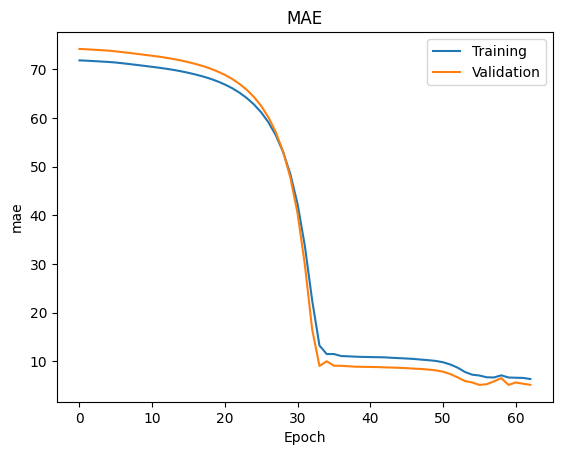

In [59]:
plt.plot(history.history['mae'], label='Training')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

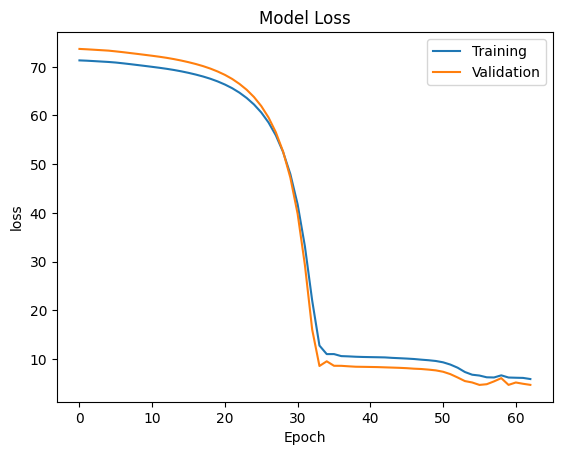

In [60]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()